# Import Library

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [203]:
df = pd.read_csv("../Dataset/dataset time series.csv")
df.head()

,TANGGAL,TN,TX,TAVG,RH_AVG,RR,SS,FF_X,DDD_X,FF_AVG,DDD_CAR
0,01-01-2020,24,29.6,26.3,88,23.5,3.4,6,280,2,C
1,02-01-2020,24.2,32.8,28.5,82,12.4,0.0,9,280,3,W
2,03-01-2020,25.8,32.0,28.2,82,0,8.3,12,300,5,NW
3,04-01-2020,26.2,31.6,28.3,82,0.4,5.8,8,300,5,W
4,05-01-2020,26.4,32.6,27.7,84,0.1,2.1,14,270,4,NW


# Data Wrangling

## 1. Penilain Data

In [204]:
df.describe()

,TX,TAVG,RH_AVG,SS,FF_X,DDD_X,FF_AVG
count,1887.000000,1887.000000,1887.00000,1887.000000,1887.000000,1887.000000,1887.000000
mean,32.078908,28.469687,80.45257,6.660996,7.403286,185.336513,2.361420
std,1.269501,1.108534,6.80323,3.352550,2.437566,85.456051,1.222689
min,26.200000,24.300000,59.00000,0.000000,0.000000,0.000000,0.000000
25%,31.400000,27.700000,76.00000,4.000000,6.000000,120.000000,1.000000
50%,32.000000,28.400000,81.00000,7.900000,7.000000,150.000000,2.000000
75%,32.800000,29.200000,86.00000,9.700000,9.000000,280.000000,3.000000
max,35.800000,32.100000,98.00000,11.700000,19.000000,360.000000,7.000000


In [205]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1887 entries, 0 to 1886
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TANGGAL  1887 non-null   object 
 1   TN       1887 non-null   object 
 2   TX       1887 non-null   float64
 3   TAVG     1887 non-null   float64
 4   RH_AVG   1887 non-null   int64  
 5   RR       1887 non-null   object 
 6   SS       1887 non-null   float64
 7   FF_X     1887 non-null   int64  
 8   DDD_X    1887 non-null   int64  
 9   FF_AVG   1887 non-null   int64  
 10  DDD_CAR  1887 non-null   object 
dtypes: float64(3), int64(4), object(4)
memory usage: 162.3+ KB
None


## Pembersihan Data

In [206]:
df = df.drop(columns=["DDD_CAR",'DDD_X'])

In [207]:
# Konversi semua kolom bertipe object ke numerik
for col in ["TN", "RR"]:
    df[col] = pd.to_numeric(df[col], errors='coerce') 

In [208]:
# Ganti nilai 8888 dan 9999 dengan None (NaN)
df = df.replace(({8888: np.nan, 9999: np.nan}))

In [209]:
print(df.isna().sum())

TANGGAL      0
TN           1
TX           0
TAVG         0
RH_AVG       0
RR         127
SS           0
FF_X         0
FF_AVG       0
dtype: int64


In [210]:
# menggantikan nilai yang hilang dengan nilai terdekat sebelumnya
df = df.ffill()

In [211]:
# Mengubah kolom 'TANGGAL' ke format datetime
df['TANGGAL'] = pd.to_datetime(df['TANGGAL'], format='%d-%m-%Y')

In [212]:
# Menambahkan Fitur Waktu
df['Hari'] = df['TANGGAL'].dt.dayofweek
df['Bulan'] = df['TANGGAL'].dt.month

In [213]:
# Menentukan musim di Indonesia (Musim Hujan dan Musim Kemarau)
def indonesia_season(month):
    if month in [11, 12, 1, 2, 3, 4]:
        return 'Musim Hujan'
    else:
        return 'Musim Kemarau'
# Menambahkan fitur Musim berdasarkan bulan
df['Musim'] = df['TANGGAL'].dt.month.apply(indonesia_season)

In [214]:
df.head()

,TANGGAL,TN,TX,TAVG,RH_AVG,RR,SS,FF_X,FF_AVG,Hari,Bulan,Musim
0,2020-01-01,24.0,29.6,26.3,88,23.5,3.4,6,2,2,1,Musim Hujan
1,2020-01-02,24.2,32.8,28.5,82,12.4,0.0,9,3,3,1,Musim Hujan
2,2020-01-03,25.8,32.0,28.2,82,0.0,8.3,12,5,4,1,Musim Hujan
3,2020-01-04,26.2,31.6,28.3,82,0.4,5.8,8,5,5,1,Musim Hujan
4,2020-01-05,26.4,32.6,27.7,84,0.1,2.1,14,4,6,1,Musim Hujan


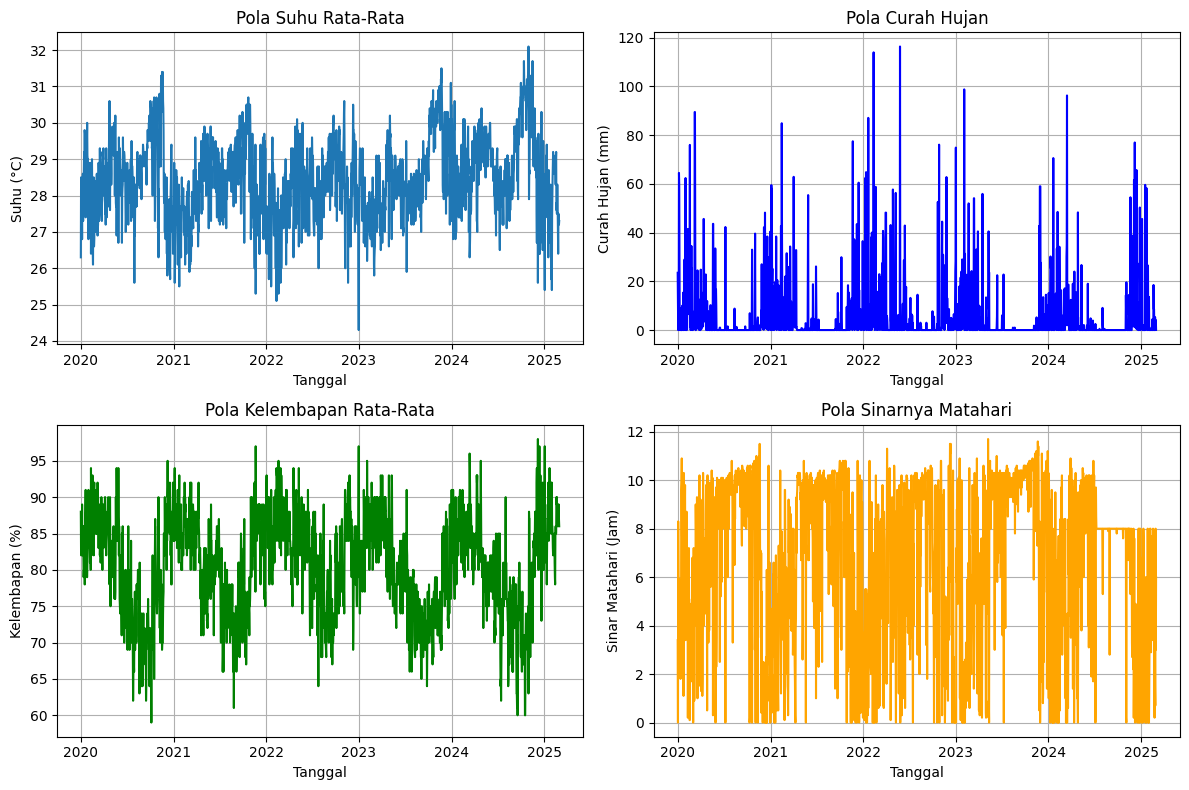

In [215]:
# Visualisasi Pola Cuaca
plt.figure(figsize=(12, 8))
# Suhu Rata-Rata
plt.subplot(2, 2, 1)
plt.plot(df['TANGGAL'], df['TAVG'], label='Suhu Rata-Rata')
plt.xlabel('Tanggal')
plt.ylabel('Suhu (°C)')
plt.title('Pola Suhu Rata-Rata')
plt.grid(True)
# Curah Hujan
plt.subplot(2, 2, 2)
plt.plot(df['TANGGAL'], df['RR'], label='Curah Hujan', color='blue')
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan (mm)')
plt.title('Pola Curah Hujan')
plt.grid(True)
# Kelembapan Rata-Rata
plt.subplot(2, 2, 3)
plt.plot(df['TANGGAL'], df['RH_AVG'], label='Kelembapan Rata-Rata', color='green')
plt.xlabel('Tanggal')
plt.ylabel('Kelembapan (%)')
plt.title('Pola Kelembapan Rata-Rata')
plt.grid(True)
# Sinarnya Matahari
plt.subplot(2, 2, 4)
plt.plot(df['TANGGAL'], df['SS'], label='Sinarnya Matahari', color='orange')
plt.xlabel('Tanggal')
plt.ylabel('Sinar Matahari (Jam)')
plt.title('Pola Sinarnya Matahari')
plt.grid(True)
# Tampilkan semua grafik
plt.tight_layout()
plt.show()

In [216]:
# Mengubah nama kolom sesuai dengan deskripsi yang lebih mudah dipahami
time_series_data = df.rename(columns={
    'TN': 'Suhu_Min',
    'TX': 'Suhu_Max',
    'RH_AVG': 'Kelembapan_Rata',
    'RR': 'Curah_Hujan',
    'SS': 'Sinar_Matahari',
    'FF_X': 'Kecepatan_Angin_Max',
    'FF_AVG': 'Kecepatan_Angin_Rata',
    'TAVG': 'Suhu_Rata_Rata',
})
time_series_data.head()

,TANGGAL,Suhu_Min,Suhu_Max,Suhu_Rata_Rata,Kelembapan_Rata,Curah_Hujan,Sinar_Matahari,Kecepatan_Angin_Max,Kecepatan_Angin_Rata,Hari,Bulan,Musim
0,2020-01-01,24.0,29.6,26.3,88,23.5,3.4,6,2,2,1,Musim Hujan
1,2020-01-02,24.2,32.8,28.5,82,12.4,0.0,9,3,3,1,Musim Hujan
2,2020-01-03,25.8,32.0,28.2,82,0.0,8.3,12,5,4,1,Musim Hujan
3,2020-01-04,26.2,31.6,28.3,82,0.4,5.8,8,5,5,1,Musim Hujan
4,2020-01-05,26.4,32.6,27.7,84,0.1,2.1,14,4,6,1,Musim Hujan


## Pembagian data training dan data testing

In [217]:
#  memprediksi suhu rata-rata (Suhu_Rata_Rata) berdasarkan fitur cuaca lainnya
fitur = ['Suhu_Min', 'Suhu_Max', 'Kelembapan_Rata', 'Curah_Hujan', 'Sinar_Matahari', 'Kecepatan_Angin_Max', 'Kecepatan_Angin_Rata', 'Bulan', 'Hari']
target = 'Suhu_Rata_Rata'

# Memisahkan fitur dan target
X = time_series_data[fitur]
y = time_series_data[target]

In [218]:
# Membagi data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("jumlah data x train: ", X_train.shape)
print("jumlah data y train: ", y_train.shape)
print("jumlah data x test: ", X_test.shape)
print("jumlah data y test: ", y_test.shape)

jumlah data x train:  (1509, 9)
jumlah data y train:  (1509,)
jumlah data x test:  (378, 9)
jumlah data y test:  (378,)


# Model Random Forest

In [235]:
# Memilih dan melatih model (Random Forest)
model_rf = RandomForestRegressor(
    n_estimators=200,    # Meningkatkan jumlah pohon
    min_samples_split=10, # Meningkatkan minimum sampel untuk pembagian
    min_samples_leaf=5,  # Meningkatkan minimum sampel di daun
    random_state=42
)

model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

In [220]:
# Evaluasi Random Forest
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100
print(f"Random Forest - MAE: {mae_rf:.4f}")
print(f"Random Forest - MSE: {mse_rf:.4f}")
print(f"Random Forest - RMSE: {rmse_rf:.4f}")
print(f"Random Forest - R² Score: {r2_rf:.4f}")
print(f"Random Forest - MAPE: {mape_rf:.4f}%")

Random Forest - MAE: 0.3474
Random Forest - MSE: 0.1968
Random Forest - RMSE: 0.4436
Random Forest - R² Score: 0.8362
Random Forest - MAPE: 1.2338%


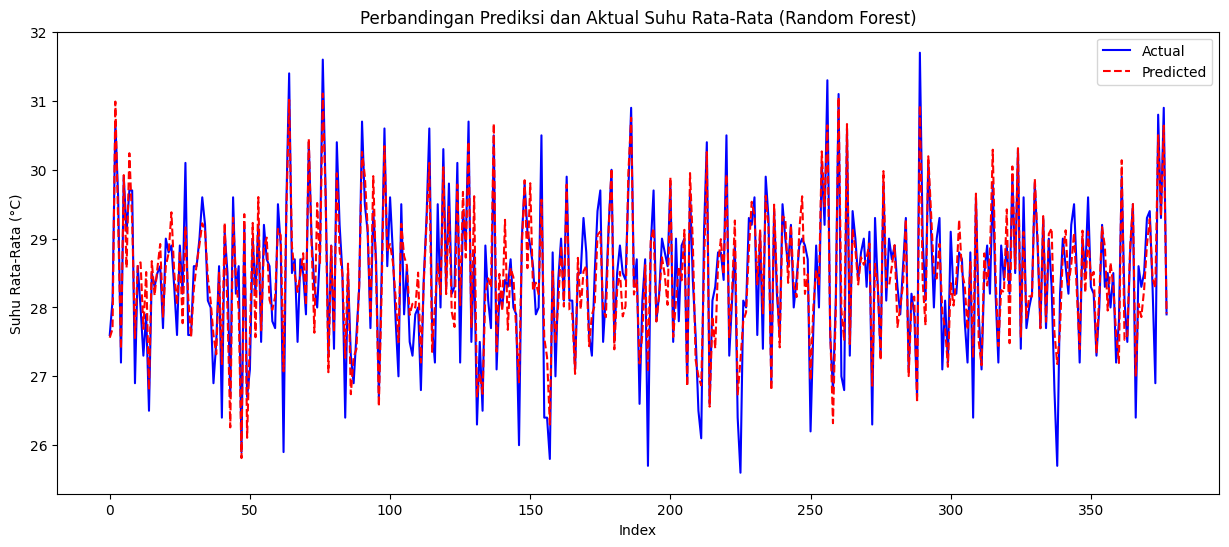

In [221]:
# Visualisasi hasil Random Forest
plt.figure(figsize=(15, 6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred_rf, label='Predicted', color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Suhu Rata-Rata (°C)')
plt.title('Perbandingan Prediksi dan Aktual Suhu Rata-Rata (Random Forest)')
plt.legend()
plt.show()

# Model Gradient Boosting

In [222]:
# Membuat dan melatih model Gradient Boosting
model_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_gb.fit(X_train, y_train)

# Memprediksi menggunakan data pengujian
y_pred_gb = model_gb.predict(X_test)

In [223]:
# Evaluasi Gradient Boosting
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting - MAE: {mae_gb:.4f}")
print(f"Gradient Boosting - MSE: {mse_gb:.4f}")
print(f"Gradient Boosting - RMSE: {rmse_gb:.4f}")
print(f"Gradient Boosting - R² Score: {r2_gb:.4f}")

Gradient Boosting - MAE: 0.3323
Gradient Boosting - MSE: 0.1829
Gradient Boosting - RMSE: 0.4276
Gradient Boosting - R² Score: 0.8478


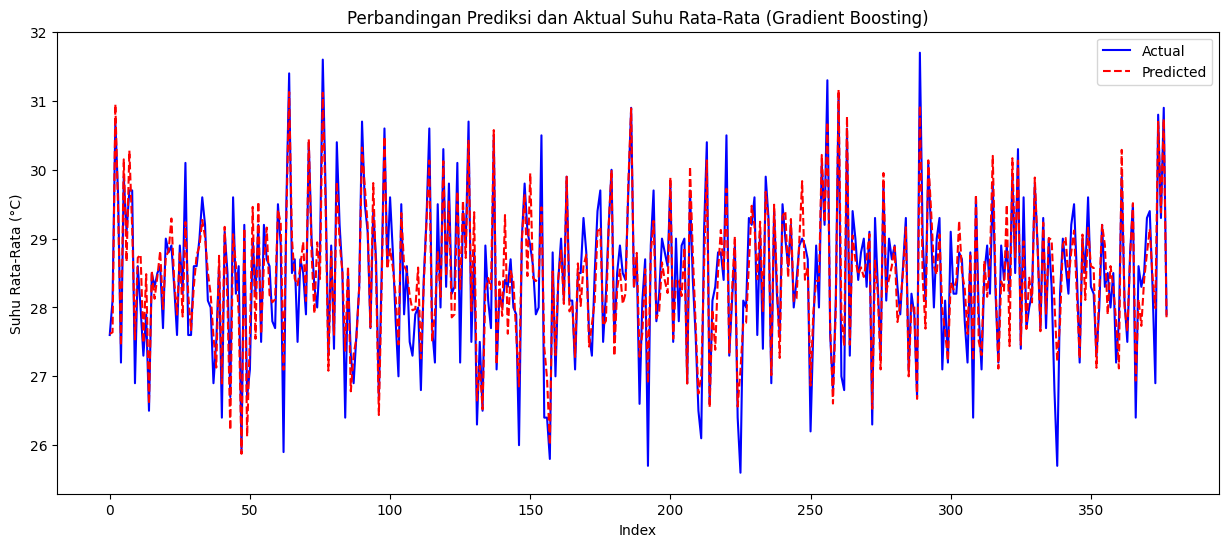

In [224]:
# Visualisasi hasil Gradient Boosting
plt.figure(figsize=(15, 6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred_gb, label='Predicted', color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Suhu Rata-Rata (°C)')
plt.title('Perbandingan Prediksi dan Aktual Suhu Rata-Rata (Gradient Boosting)')
plt.legend()
plt.show()

# Model XGBoost 

In [225]:
# Buat model XGBoost Regressor
model_xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
model_xgb.fit(X_train, y_train)
# Prediksi
y_pred_xgb = model_xgb.predict(X_test)

In [228]:
# Evaluasi XGBoost Regressor
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_gb = np.sqrt(mse_xgb)
r2_gb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - MAE: {mae_gb:.4f}")
print(f"XGBoost - MSE: {mse_gb:.4f}")
print(f"XGBoost - RMSE: {rmse_gb:.4f}")
print(f"XGBoost - R² Score: {r2_gb:.4f}")

XGBoost - MAE: 0.3276
XGBoost - MSE: 0.1764
XGBoost - RMSE: 0.4200
XGBoost - R² Score: 0.8532


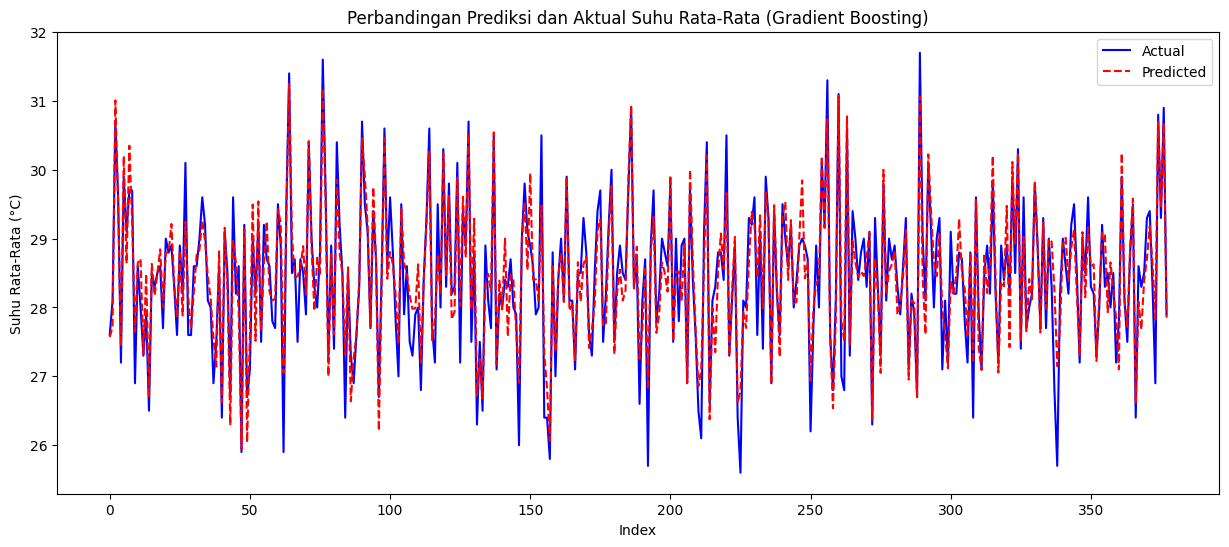

In [227]:
# Visualisasi hasil Gradient Boosting
plt.figure(figsize=(15, 6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred_xgb, label='Predicted', color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Suhu Rata-Rata (°C)')
plt.title('Perbandingan Prediksi dan Aktual Suhu Rata-Rata (Gradient Boosting)')
plt.legend()
plt.show()